In [2]:
# 1. 환경 설정 및 데이터 로드

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 경로 설정
DATA_PATH = '../data/PCB_DATASET/'
IMAGE_PATH = os.path.join(DATA_PATH, 'images')
ANNOTATION_PATH = os.path.join(DATA_PATH, 'Annotations')

# 결함 클래스 정의
DEFECT_CLASSES = [
    'Missing_hole',      # 구멍 누락
    'Mouse_bite',        # 마우스 바이트
    'Open_circuit',      # 단선
    'Short',             # 합선
    'Spur',              # 돌기
    'Spurious_copper'    # 이물질 구리
]

print(f"PCB 결함 검사 데이터 분석")
print(f"=" * 60)
print(f"\n검사 대상: {len(DEFECT_CLASSES)}가지 결함 유형")
for i, defect in enumerate(DEFECT_CLASSES, 1):
    print(f"   {i}. {defect}")

# 각 클래스별 이미지 개수 확인
print(f"\n클래스별 데이터 개수:")
print(f"-" * 60)

total_images = 0
class_counts = {}

for defect_class in DEFECT_CLASSES:
    class_path = os.path.join(IMAGE_PATH, defect_class)
    
    if os.path.exists(class_path):
        images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png'))]
        count = len(images)
        class_counts[defect_class] = count
        total_images += count
        print(f"   {defect_class:20s}: {count:4d}개")
    else:
        print(f"   {defect_class:20s}: 폴더 없음")

print(f"-" * 60)
print(f"   {'총 이미지 수':20s}: {total_images:4d}개")
print(f"\n데이터 로드 완료")


PCB 결함 검사 데이터 분석

검사 대상: 6가지 결함 유형
   1. Missing_hole
   2. Mouse_bite
   3. Open_circuit
   4. Short
   5. Spur
   6. Spurious_copper

클래스별 데이터 개수:
------------------------------------------------------------
   Missing_hole        :  115개
   Mouse_bite          :  115개
   Open_circuit        :  116개
   Short               :  116개
   Spur                :  115개
   Spurious_copper     :  116개
------------------------------------------------------------
   총 이미지 수             :  693개

데이터 로드 완료


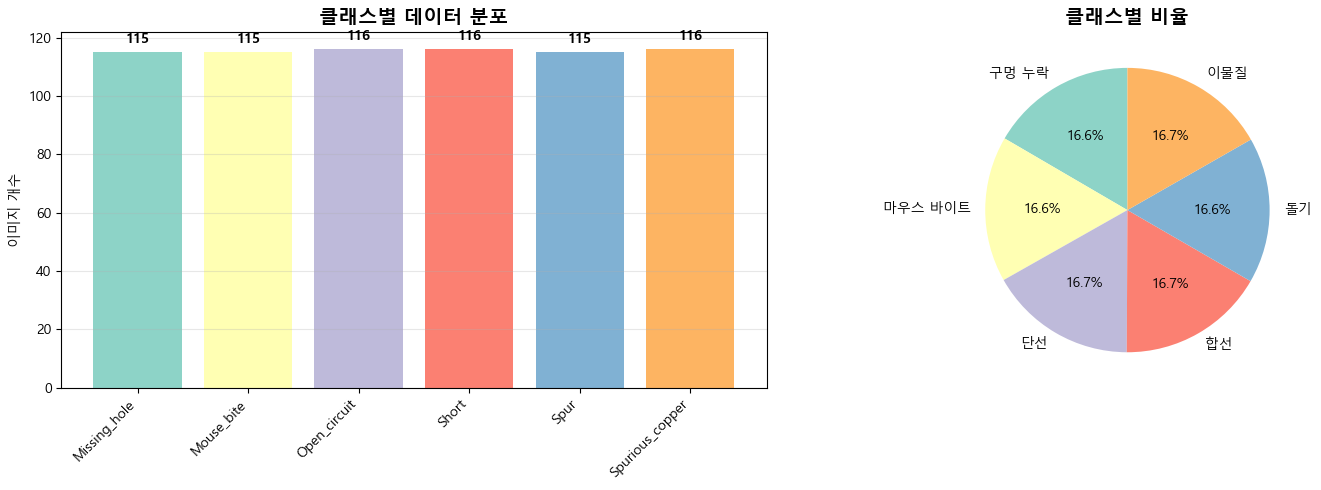


 데이터 균형도 분석:
------------------------------------------------------------
   평균: 115.5개
   표준편차: 0.55개
   최소: 115개
   최대: 116개


In [ ]:
# 2. 클래스 분포 시각화

# 데이터프레임 생성
df_class = pd.DataFrame({
    'Class': list(class_counts.keys()),
    'Count': list(class_counts.values())
})

# 한글 클래스명 매핑 (선택)
class_name_kr = {
    'Missing_hole': '구멍 누락',
    'Mouse_bite': '마우스 바이트',
    'Open_circuit': '단선',
    'Short': '합선',
    'Spur': '돌기',
    'Spurious_copper': '이물질'
}
df_class['Class_KR'] = df_class['Class'].map(class_name_kr)

# 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 막대 그래프
colors = plt.cm.Set3(range(len(DEFECT_CLASSES)))
ax1.bar(range(len(df_class)), df_class['Count'], color=colors)
ax1.set_xticks(range(len(df_class)))
ax1.set_xticklabels(df_class['Class'], rotation=45, ha='right')
ax1.set_ylabel('이미지 개수')
ax1.set_title('클래스별 데이터 분포', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# 각 막대 위에 숫자 표시
for i, (idx, row) in enumerate(df_class.iterrows()):
    ax1.text(i, row['Count'] + 2, str(row['Count']), 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 파이 차트
ax2.pie(df_class['Count'], labels=df_class['Class_KR'], autopct='%1.1f%%',
        colors=colors, startangle=90)
ax2.set_title('클래스별 비율', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n 데이터 균형도 분석:")
print(f"-" * 60)
mean_count = df_class['Count'].mean()
std_count = df_class['Count'].std()
print(f"   평균: {mean_count:.1f}개")
print(f"   표준편차: {std_count:.2f}개")
print(f"   최소: {df_class['Count'].min()}개")
print(f"   최대: {df_class['Count'].max()}개")

# 결론: 데이터가 비교적 균형을 이루고 있음

   Missing_hole        : 01_missing_hole_01.jpg         - 크기: (1586, 3034, 3)
   Mouse_bite          : 01_mouse_bite_01.jpg           - 크기: (1586, 3034, 3)
   Open_circuit        : 01_open_circuit_01.jpg         - 크기: (1586, 3034, 3)
   Short               : 01_short_01.jpg                - 크기: (1586, 3034, 3)
   Spur                : 01_spur_01.jpg                 - 크기: (1586, 3034, 3)
   Spurious_copper     : 01_spurious_copper_01.jpg      - 크기: (1586, 3034, 3)

 샘플 이미지 로드 완료


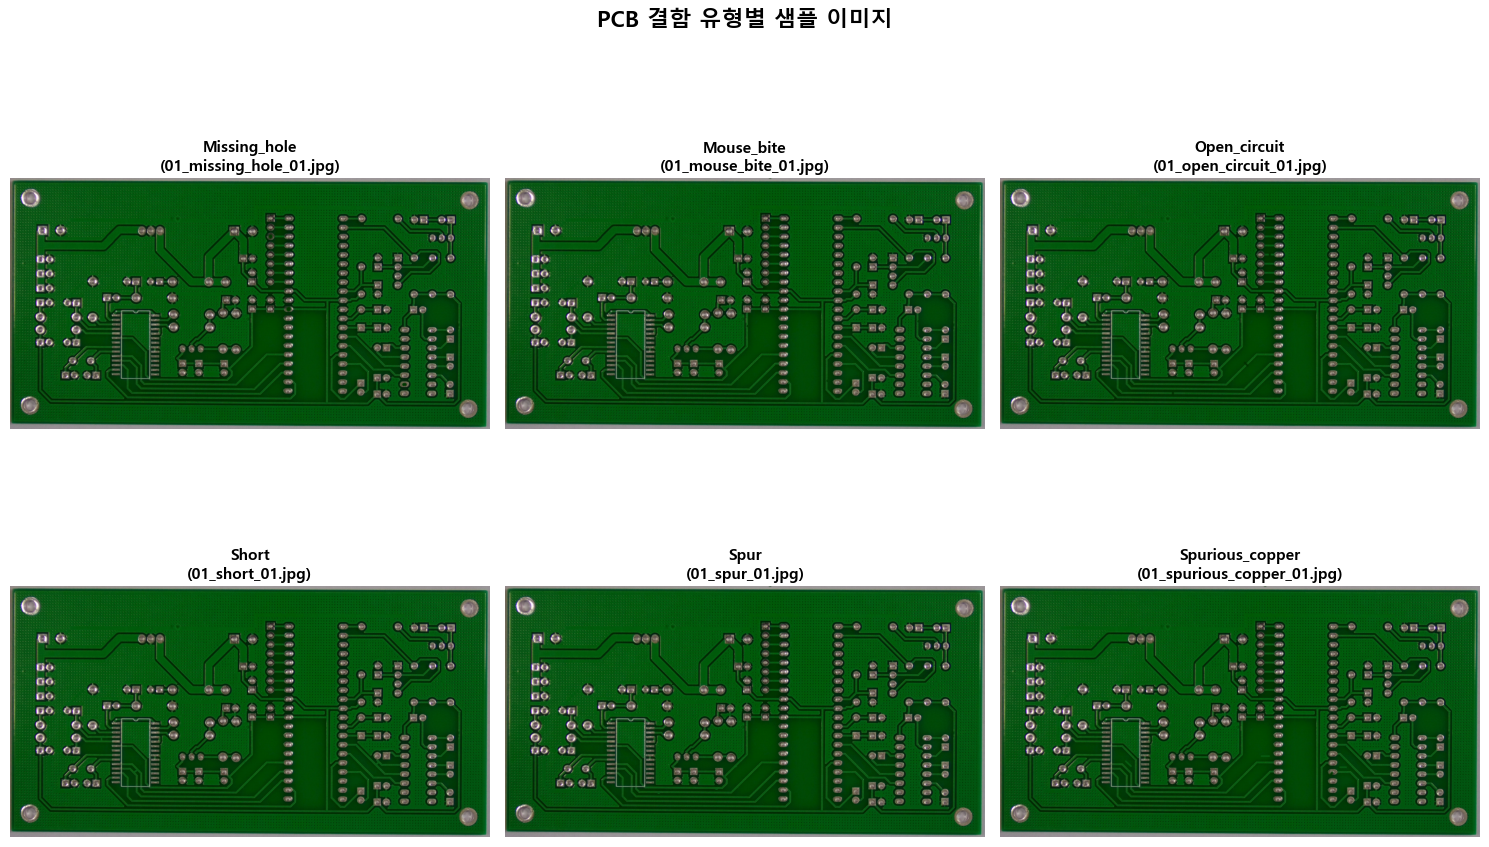

In [ ]:
# 3. 샘플 이미지 확인

# 각 클래스에서 첫 번째 이미지 1개씩 로드
sample_images = {}
sample_paths = {}

for defect_class in DEFECT_CLASSES:
    class_path = os.path.join(IMAGE_PATH, defect_class)
    image_files = sorted([f for f in os.listdir(class_path) 
                         if f.endswith(('.jpg', '.png'))])
    
    if len(image_files) > 0:
        # 첫 번째 이미지 로드
        img_path = os.path.join(class_path, image_files[0])
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        sample_images[defect_class] = img_rgb
        sample_paths[defect_class] = image_files[0]
        
        print(f"   {defect_class:20s}: {image_files[0]:30s} - 크기: {img.shape}")

print(f"\n 샘플 이미지 로드 완료")

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, defect_class in enumerate(DEFECT_CLASSES):
    if defect_class in sample_images:
        axes[i].imshow(sample_images[defect_class])
        axes[i].set_title(f'{defect_class}\n({sample_paths[defect_class]})', 
                         fontsize=11, fontweight='bold')
        axes[i].axis('off')

plt.suptitle('PCB 결함 유형별 샘플 이미지', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# - 각 결함의 특징이 육안으로 구분 가능한가? No

In [6]:
# 3-1 이미지 해상도와 품질이 적절한지 확인

# 모든 이미지 크기 확인
all_sizes = []

for defect_class in DEFECT_CLASSES:
    class_path = os.path.join(IMAGE_PATH, defect_class)
    image_files = [f for f in os.listdir(class_path) 
                   if f.endswith(('.jpg', '.png'))]
    
    for img_file in image_files[:10]:  # 각 클래스에서 10개만 확인
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            all_sizes.append(img.shape)

# 통계
heights = [s[0] for s in all_sizes]
widths = [s[1] for s in all_sizes]

print(f"\n 이미지 크기 통계:")
print(f"-" * 60)
print(f"   높이 - 최소: {min(heights)}px, 최대: {max(heights)}px, 평균: {np.mean(heights):.0f}px")
print(f"   너비 - 최소: {min(widths)}px, 최대: {max(widths)}px, 평균: {np.mean(widths):.0f}px")

# 고유한 크기들
unique_sizes = list(set([(h, w) for h, w, c in all_sizes]))
print(f"\n   발견된 이미지 크기: {len(unique_sizes)}가지")
for size in unique_sizes:
    print(f"      - {size[0]} x {size[1]}")

# 판단
avg_size = np.mean(heights)

# 해상도 적절성 판단

if avg_size < 224:
    assessment = "너무 낮음"
    recommendation = "업스케일 필요"
elif avg_size < 416:
    assessment = "낮은 편"
    recommendation = "경량 모델 사용 또는 업스케일 고려"
elif avg_size < 640:
    assessment = "적절함 (저~중해상도)"
    recommendation = "그대로 사용 가능, YOLO 기본 설정"
elif avg_size < 1024:
    assessment = "적절함 (중~고해상도)"
    recommendation = "고정밀 검사에 적합"
else:
    assessment = "매우 높음"
    recommendation = "다운샘플링으로 속도 개선 가능"

print(f"   평균 해상도: {avg_size:.0f}px")
print(f"   평가: {assessment}")
print(f"   권장사항: {recommendation}")

# GPU 메모리 고려
if avg_size <= 416:
    print(f"   현재 크기({avg_size:.0f}px)로 학습 가능")
    print(f"   권장 배치 크기: 8~16")
elif avg_size <= 640:
    print(f"   다운샘플링 권장: {avg_size:.0f}px → 416px")
    print(f"   이유: 2GB VRAM에서 안정적 학습")
    print(f"   다운샘플링 시 배치 크기: 8~16")
    print(f"   원본 유지 시 배치 크기: 4~8")
else:
    print(f"   다운샘플링 필수: {avg_size:.0f}px → 416px")
    print(f"   이유: 메모리 부족 위험")



 이미지 크기 통계:
------------------------------------------------------------
   높이 - 최소: 1586px, 최대: 1586px, 평균: 1586px
   너비 - 최소: 3034px, 최대: 3034px, 평균: 3034px

   발견된 이미지 크기: 1가지
      - 1586 x 3034
   평균 해상도: 1586px
   평가: 매우 높음
   권장사항: 다운샘플링으로 속도 개선 가능
   다운샘플링 필수: 1586px → 416px
   이유: 메모리 부족 위험



 샘플 이미지: 01_missing_hole_01.jpg
   원본 크기: 3034 x 1586


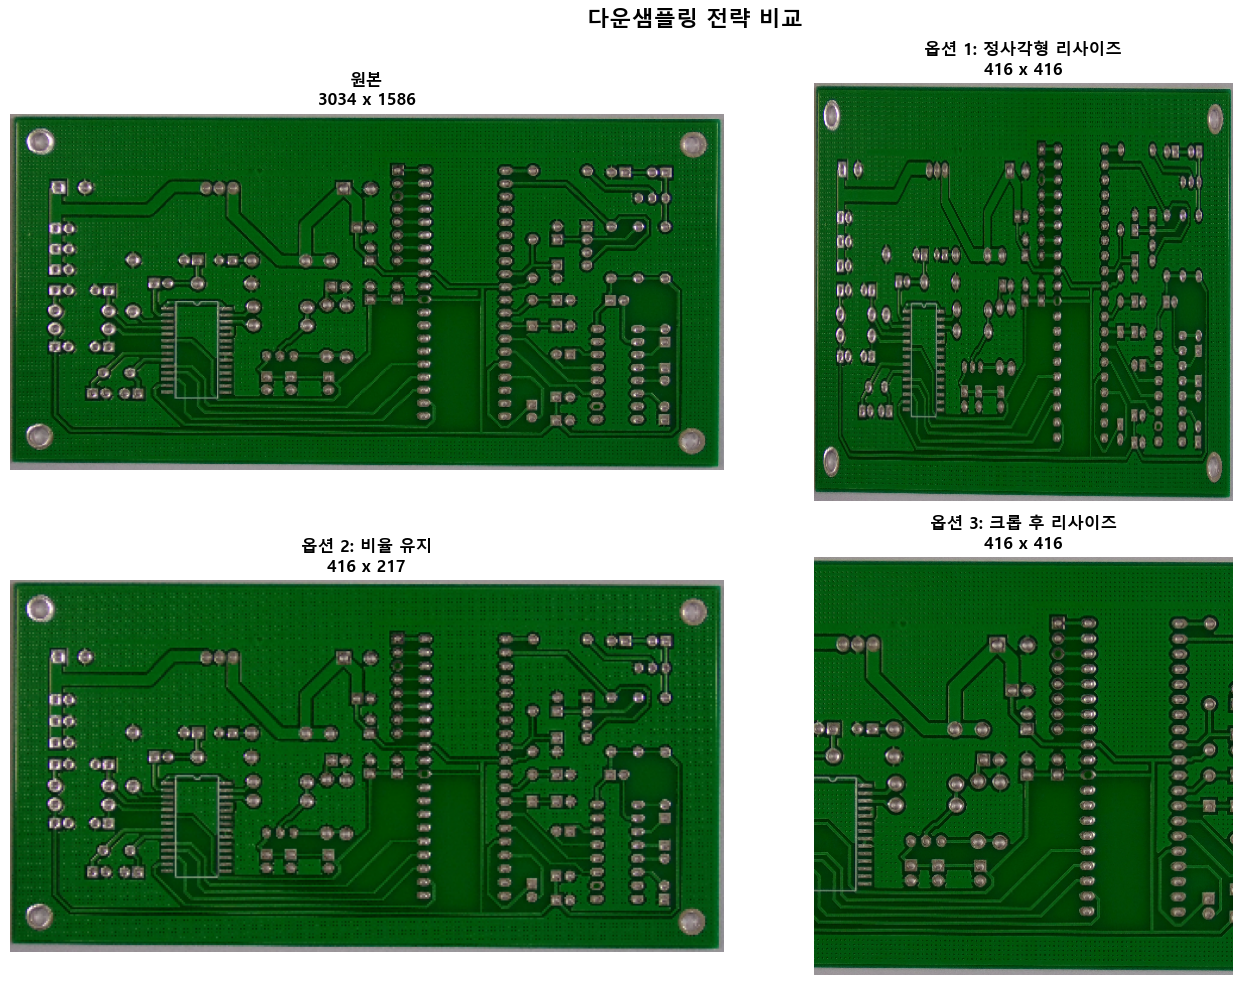

In [9]:
# 4. 다운샘플링 전략 비교

# 샘플 이미지 1개 가져오기
sample_class = DEFECT_CLASSES[0]
sample_path = os.path.join(IMAGE_PATH, sample_class)
sample_file = sorted(os.listdir(sample_path))[0]
sample_img_path = os.path.join(sample_path, sample_file)

# 원본 이미지 로드
original = cv2.imread(sample_img_path)
original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

print(f"\n 샘플 이미지: {sample_file}")
print(f"   원본 크기: {original.shape[1]} x {original.shape[0]}")

# 3가지 리사이즈 방법
TARGET_SIZE = 416

# 1. 정사각형 (비율 무시)
# 장점: YOLO 표준, 학습 안정적, 메모리 효율
# 단점: 가로 비율 왜곡 (1.91배 압축)
# 파일 크기 감소: 약 95% (15MB → 0.5MB)
resized_square = cv2.resize(original_rgb, (TARGET_SIZE, TARGET_SIZE))

# 2. 비율 유지 (가로 기준)
# 장점: 원본 비율 유지
# 단점: YOLO 비표준, 가로로 너무 긴 형태
aspect_ratio = original.shape[0] / original.shape[1]
new_height = int(TARGET_SIZE * aspect_ratio)
resized_ratio = cv2.resize(original_rgb, (TARGET_SIZE, new_height))

# 3. 크롭 후 리사이즈 (정사각형 영역만)
# 장점: 정사각형, 중앙 집중
# 단점: 가장자리 정보 손실
h, w = original.shape[:2]
crop_size = min(h, w)
start_y = (h - crop_size) // 2
start_x = (w - crop_size) // 2
cropped = original_rgb[start_y:start_y+crop_size, start_x:start_x+crop_size]
resized_crop = cv2.resize(cropped, (TARGET_SIZE, TARGET_SIZE))

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 원본 (축소해서 표시)
axes[0, 0].imshow(cv2.resize(original_rgb, (600, 300)))
axes[0, 0].set_title(f'원본\n{original.shape[1]} x {original.shape[0]}', 
                     fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# 옵션 1: 정사각형
axes[0, 1].imshow(resized_square)
axes[0, 1].set_title(f'옵션 1: 정사각형 리사이즈\n{TARGET_SIZE} x {TARGET_SIZE}', 
                     fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

# 옵션 2: 비율 유지
axes[1, 0].imshow(resized_ratio)
axes[1, 0].set_title(f'옵션 2: 비율 유지\n{TARGET_SIZE} x {new_height}', 
                     fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

# 옵션 3: 크롭 후 리사이즈
axes[1, 1].imshow(resized_crop)
axes[1, 1].set_title(f'옵션 3: 크롭 후 리사이즈\n{TARGET_SIZE} x {TARGET_SIZE}', 
                     fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

plt.suptitle('다운샘플링 전략 비교', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 결론: 정사각형 리사이즈가 YOLO에 적합하여 옵션1 선택
